# Exercício 1 - Problema da fabricação de garrafas

Você gerencia uma fábrica de garrafas plásticas que tem apenas uma máquina extrusora. Esta máquina pode funcionar até 60 horas por semanda, isto é, 6 dias por semana com jornada de 10 horas por dia. A máquina é capaz de produzir dois tipos de garrafas plásticas: tipo "leite" e tipo "suco". Toda a produção semanal de garrafas plásticas é armazenada temporariamente num depósito. No domingo toda a produção é despachada para os compradores e o depósito é esvaziado completamente.  

A linha de produção leva 6 horas para produzir 100 garrafas tipo leite e 5 horas para produzir 100 garrafas tipo suco. Cada Carrafa tipo leite ocupa 10 unidades cúbicas de espaço no depósito, enquanto que a garrafa de tipo suco ocupa 20 unidades cúbicas. O depósito tem capacidade máxima de 15000 unidades cúbicas.  

A contribuição no lucro final da empresa por garrafa tipo leite é de 5 unidades monetárias e por garrafa tipo suco é de 4,5. O departamento de vendas tem contratos de fornecimento capazes de absorver toda a produção possível de garrafas tipo suco, porém tem compradores somente para 800 garrafastipo leite por semana.  

Você deve estabelecer qual é o plano de produção mais adequado para maximizar o lucro total da empresa, isto é, quantas garrafas tipo Leite e quantos tipoo Suco devem ser produzidas semanalmente.

##Roteiro:
1. Identifique a natureza do problema de otimização
2. Identifique o conjunto de variáveis do problema
3. Desenvolva uma codificação apropriada para o conjunto de variáveis
4. Identifique e formule matematicamente as restrições do problema
5. Identifique a(s) função(ões) objetivo(s)
6. Desenvolva uma função de fitness adequada
7. Descreva o processo de satisfação das restrições
8. Implemente a solução proposta utilizando algoritmos genéticos

### 1 - Natureza do problema
Problema de maximização do lucro final e tem apenas um critério/objetivo(lucro) a ser maximizado  

In [2]:
import random
import numpy
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

# INIT
toolbox = base.Toolbox()

In [3]:
# Definindo a natureza do problema. No caso um problema de maximização
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

### 2 - Variáveis
Temos somente duas variáveis: _quantidade de garrafas de leite_ e _quantidades de garrafas de suco_. Sendo assim o cromossomo será formado por dois genes correspondetes a essas variáveis. 

### 3 - Codificação
Cada uma das variáveis só pode assumir valores inteiros. Logo precisa-se primeiramente definir o intervalo de valores possíveis para entao definir a quantidade de bits necessários

- Garrafa de suco  
-- Limite inferior = 0  
-- Limite superior = $\frac{limiteEstoque}{volumetriaGarrafaSuco} = \frac{15000}{20} = 750$  
-- Bits = $2^{10} = 1024 > 750$  

- Garrafa de leite  
-- Limite inferior = 0  
-- Limite superior = 800 (limite definido pelos compradores)  
-- Bits = $2^{10} = 1024 > 800$ 

In [4]:
# Definindo a estrutura do indivíduo
IND_SIZE = 20  # Tamanho do individuo - 10 para cada gene
GENES = 2
creator.create("Individual", list, fitness=creator.FitnessMax)

# funcao para gerar o gene com valores 0 ou 1 randomicamente uniforme
toolbox.register("attr_bool", random.randint, 0, 1)
# funcao para gerar o indivíduo (nome, forma de gerar, Estrutura, funcao geradora, tamanho)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=IND_SIZE)

# funcao para gerar a populacao
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### 4 - Restrições  
As restrições servem para definir um limite de soluções possíveis para algoritmo e, dependendo da abordagem, penalizar a função de fitness ou apenas descartas as soluções com respostas fora do intervalo.  


- Máximo tempo de utilização da máquina  
$$ \begin{eqnarray} HorasPorGarrafaLeite*L +HorasPorGarrafaSuco*S \le 60 \end{eqnarray} $$
$$ \begin{eqnarray} \frac{6}{100}*L + \frac{5}{100}*S \le 60 \end{eqnarray} $$
$$ \begin{eqnarray} 0.06*L + 0.05*S \le 60 \end{eqnarray} $$  

- Máximo espeaço disponível no depósito  
$$ \begin{eqnarray} VolumeGarraLeite*L + VolumeGarrafaSuco*S \le 15000 \end{eqnarray} $$
$$ \begin{eqnarray} 10*L + 20*S \le 15000 \end{eqnarray} $$

- Máxima demanda de garrafas de leite  
$$ L \le 800 $$  

- Máxima produção possível de garrafas de suco  
$$ S \le 750 $$ 

De forma resumida temos as seguintes funções de restrições:
$$ r_1(L,S) = 0.06*L + 0.05*S \le 60 $$
$$ r_2(L,S) = 10*L + 20*S \le 15000 $$
$$ r_3(L,S) = L \le 800 $$
$$ r_4(L,S) = S \le 750 $$  


### 5 - Função objetivo
Modela a função a qual o problema destina-se a resolver. A função de fitness usará essa função de objetivo como base e pode ou não aplicar penalidades com base nas restrições.  
Tendo-se o custo de cada garrafa, temos a seguinte função objetivo: $$ g(L,S) = 5*L + 4,5*S $$  

### 6 - Função de fitness
Uma boa prática para a função de fitness é fazer com que ela varie no intervalo [0,1] para visulizar mais facilmente seu crescimento. Tendo em vista as restrições que temos para o problema, uma boa abordagem para a função de fitness(conforme proposto por Goldberg) é a seguinte: $$ f(L,S) = g_n(L,S) - \Phi $$  
Onde $ g_n(L,S) $ é a função objetivo normalizada no intervalo [0,1] e $\Phi$ é a soma das funções de restrições, também normalizada no intervalo [0,1].  

Grosseiramente, podemos assumir que o máximo valor possível de $g(L,S)$ é: $5*QntdLimiteDeLeite + 4,5*QndtLimiteDeSuco = 5*800 + 4,5*750 = 7375 $. Sendo assim temos que: $$ g_n(L,S) = \frac{5*L + 4,5*S}{7475} $$

Para a função $\Phi$ temos que determinar as funções de restrição $h_i$ para que retornem um valor positivo proporcional à violação de seus limites e um valor nulo quando isso não ocorrer. Sendo assim, temos:
$$ h_1(L,S) = max{0, 0.06*L + 0.05*S - 60} $$
$$ h_2(L,S) = max{0, 10*L + 20*S - 15000} $$
$$ h_3(L,S) = max{0, L - 800} $$
$$ h_4(L,S) = max{0, S - 750} $$

Normalizando cada uma delas, tem-se:
$$ h_1(L,S) = \frac{max{0, 0.06*L + 0.05*S - 60}}{60} $$
$$ h_2(L,S) = \frac{max{0, 10*L + 20*S - 15000}}{1500} $$
$$ h_3(L,S) = \frac{max{0, L - 800}}{800} $$
$$ h_4(L,S) = \frac{max{0, S - 750}}{750} $$

Sendo $\Phi$ a soma de todas as $h_i$, tem-se $\Phi$ normalizada:
$$\Phi = \frac{\frac{max{0, 0.06*L + 0.05*S - 60}}{60} +
\frac{max{0, 10*L + 20*S - 15000}}{1500} +
\frac{max{0, L - 800}}{800} +
\frac{max{0, S - 750}}{750}}{4}$$

Portanto a função de fitness resultante é:
$$f(L,S) = \frac{5*L + 4,5*S}{7475} - \frac{\frac{max{0, 0.06*L + 0.05*S - 60}}{60} +
\frac{max{0, 10*L + 20*S - 15000}}{1500} +
\frac{max{0, L - 800}}{800} +
\frac{max{0, S - 750}}{750}}{4}$$

#### Operadores
São eles CrossOver, Mutação, Evolução e Seleção

### 8 - Código AG
Implementação de Algoritmo Genético para resolução do problema

#### Operadores
São eles CrossOver, Mutação, Evolução e Seleção

In [6]:
# registra funcao de fitness
toolbox.register("evaluate", evaluate)

# registra crossOver
toolbox.register("mate", tools.cxTwoPoint)

# registra mutacao com probabilidade default de mudar cada gene de 5%
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

# registra o metodo de selecao como torneio de tamanho 3
toolbox.register("select", tools.selTournament, tournsize=2)

gen	nevals	std    	min     	avg      	max     
0  	100   	1.97913	-7.88209	-0.861425	0.677559
1  	50    	1.03551	-5.63605	0.0127599	0.677559
2  	62    	0.424573	-2.80102	0.379373 	0.696   
3  	56    	0.152689	-0.154328	0.496669 	0.696   
4  	39    	0.415225	-2.84261 	0.491398 	0.696   
5  	63    	0.412363	-2.97151 	0.496557 	0.696   
6  	45    	0.250381	-0.946401	0.543374 	0.696   


7  	45    	0.126838	0.119593 	0.583522 	0.696   
8  	55    	0.195678	-0.498531	0.588705 	0.696   
9  	53    	0.11309 	-0.0251299	0.628333 	0.696   
10 	47    	0.0666772	0.244362  	0.660244 	0.696   
11 	42    	0.147392 	-0.38061  	0.644671 	0.696   
12 	52    	0.174249 	-1.04507  	0.66786  	0.696   
13 	45    	0.0208799	0.490192  	0.691828 	0.696   
14 	49    	0.00132131	0.683797  	0.69575  	0.696   
15 	60    	0.000180594	0.694644  	0.695974 	0.696   
16 	57    	0.2554     	-1.85072  	0.665882 	0.696678
17 	48    	0.0154773  	0.540475  	0.694396 	0.696   
18 	52    	1.11022e-16	0.696     	0.696    	0.696   
19 	48    	1.11022e-16	0.696     	0.696    	0.696   
20 	54    	0.0162628  	0.539797  	0.693849 	0.696   
21 	52    	1.11022e-16	0.696     	0.696    	0.696   


22 	48    	1.11022e-16	0.696     	0.696    	0.696   
23 	43    	1.11022e-16	0.696     	0.696    	0.696   
24 	51    	0.0022073  	0.674034  	0.695732 	0.696   
25 	38    	1.11022e-16	0.696     	0.696    	0.696   
26 	37    	0.202093   	-1.33511  	0.675689 	0.696   
27 	58    	0.498647   	-4.31559  	0.645884 	0.696   
28 	42    	0.015542   	0.539797  	0.694438 	0.696   
29 	51    	0.0192859  	0.502169  	0.694062 	0.696   
30 	54    	1.11022e-16	0.696     	0.696    	0.696   
31 	56    	0.0298472  	0.461695  	0.69176  	0.696   
32 	39    	0.0188744  	0.506305  	0.694103 	0.696   
33 	48    	0.000269827	0.693288  	0.695973 	0.696   
34 	54    	0.0461292  	0.232384  	0.691364 	0.696   
35 	48    	0.00522115 	0.643525  	0.695475 	0.696   
36 	49    	0.328113   	-2.60169  	0.662981 	0.696   
37 	63    	1.11022e-16	0.696     	0.696    	0.696   
38 	44    	0.000973885	0.686237  	0.695908 	0.69661 
39 	66    	0.0468858  	0.232384  	0.690451 	0.69661 
40 	55    	0.202121   	-1.33511  	0.675023 	0.

42 	37    	0.498647   	-4.31559  	0.645883 	0.69661 
43 	62    	0.000506514	0.691119  	0.695982 	0.69661 
44 	41    	0.0904903  	-0.0254237	0.683225 	0.69661 
45 	52    	0.0339062  	0.364723  	0.691912 	0.69661 
46 	48    	0.0470264  	0.232384  	0.690114 	0.69661 
47 	38    	0.000590826	0.691119  	0.696195 	0.69661 
48 	43    	0.0338008  	0.356667  	0.692959 	0.696678
49 	54    	0.0213287  	0.482136  	0.694339 	0.696678
50 	54    	0.000611709	0.691119  	0.696514 	0.696678
51 	53    	0.000556542	0.691729  	0.696532 	0.696678
52 	49    	0.000589398	0.693955  	0.696454 	0.696678
53 	46    	0.0441778  	0.252407  	0.69191  	0.696678
54 	48    	0.00069006 	0.693955  	0.696375 	0.696678
55 	56    	0.000732844	0.693955  	0.696354 	0.696678
56 	58    	0.000653263	0.693955  	0.696412 	0.696678
57 	55    	0.00117893 	0.686847  	0.696289 	0.696678
58 	42    	0.00060815 	0.693955  	0.696471 	0.696678
59 	47    	0.558146   	-4.32158  	0.620805 	0.696678
60 	56    	0.499299   	-4.32158  	0.646373 	0.


66 	42    	0.0160817  	0.535051  	0.695062 	0.696678
67 	56    	0.0335244  	0.359729  	0.693284 	0.696678
68 	56    	2.22045e-16	0.696678  	0.696678 	0.696678
69 	61    	0.0345379  	0.349559  	0.693207 	0.696678
70 	48    	0.0336238  	0.358734  	0.693244 	0.696678
71 	49    	0.0162031  	0.533831  	0.695049 	0.696678
72 	52    	2.22045e-16	0.696678  	0.696678 	0.696678
73 	41    	0.00890429 	0.607186  	0.695783 	0.696678
74 	45    	0.499285   	-4.32158  	0.645964 	0.696678
75 	58    	2.22045e-16	0.696678  	0.696678 	0.696678
76 	33    	0.203253   	-1.3461   	0.67625  	0.696678
77 	50    	2.22045e-16	0.696678  	0.696678 	0.696678
78 	47    	2.22045e-16	0.696678  	0.696678 	0.696678
79 	61    	0.552999   	-4.85927  	0.638987 	0.696678
80 	60    	0.000485689	0.691797  	0.696629 	0.696678
81 	54    	0.0434478  	0.266249  	0.691579 	0.696678
82 	56    	0.499309   	-4.32158  	0.646475 	0.696678
83 	56    	2.22045e-16	0.696678  	0.696678 	0.696678
84 	62    	0.070476   	-0.0116328	0.689595 	0


93 	55    	0.00917412 	0.604475  	0.695756 	0.696678
94 	55    	0.0261124  	0.484203  	0.692991 	0.696678
95 	52    	0.0765275  	-0.072452 	0.688987 	0.696678
96 	55    	0.0147281  	0.548655  	0.695198 	0.696678
97 	43    	0.0316227  	0.378847  	0.693487 	0.696678
98 	42    	2.22045e-16	0.696678  	0.696678 	0.696678
99 	52    	0.033625   	0.358734  	0.693299 	0.696678
100	52    	0.025559   	0.451254  	0.693338 	0.696678


Quantidade de garrafas de leite: 655
Quantidade de garrafas de suco: 414
Lucro ótimo: 5138.0


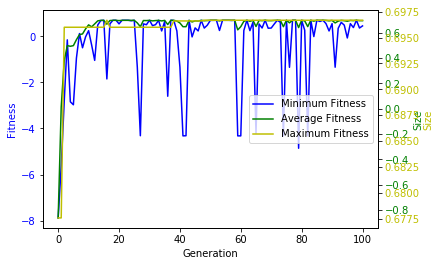

In [7]:
# ----------
# ALGORITMO
# ----------
def main():
    random.seed(94)

    # cria populacao inicial
    pop = toolbox.population(n=100)

    # MU - numero de individuos selecionados para a prox geracao
    # LAMBDA - numero de filhos a serem gerados
    # CXPB - probabilidade de crossover
    # MUTPB - probabilidade de mutacao
    # NGEN - numero de geracoes
    MU, LAMBDA_, CXPB, MUTPB, NGEN = 5, 7, 0.5, 0.02, 100
    #CXPB, MUTPB, NGEN = 0.5, 0.2, 200  # LUCR0 = 5138

    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("avg", numpy.mean)
    stats.register("max", numpy.max)

    #Algoritmos do livro “Evolutionary Computation 1 : Basic Algorithms and Operators”
    #roda o algoritmo do capitulo 7
    pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats=stats, verbose=True)

    #roda o algoritmo (mi  ,lambda)
    #pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, MU, LAMBDA_, CXPB, MUTPB, NGEN, stats=stats, verbose=True)

    # roda o algoritmo (mi + lambda)
    #pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA_, CXPB, MUTPB, NGEN, stats=stats, verbose=True)

    #Seleciona o melhor individuo da populacao resultante
    best_ind = tools.selSPEA2(pop, 1)

    #Imprime as infromações do melhor individuo
    print_ind(best_ind[0])

    plot_log(logbook)

def print_ind(individual):
    l = int("".join(str(i) for i in individual[:int(IND_SIZE / GENES)]), 2)  # gene quantidade de garrafas de leite
    s = int("".join(str(i) for i in individual[int(IND_SIZE / GENES):]), 2)  # gene quantidade de garrafas de suco
    g = 5*l + 4.5*s
    print('Quantidade de garrafas de leite: ' + str(l))
    print('Quantidade de garrafas de suco: ' + str(s))
    print('Lucro ótimo: ' + str(g))


def plot_log(logbook):
    gen = logbook.select("gen")
    min = logbook.select("min")
    avg = logbook.select("avg")
    max = logbook.select("max")

    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, min, "b-", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, avg, "g-", label="Average Fitness")
    ax2.set_ylabel("Size", color="g")
    for tl in ax2.get_yticklabels():
        tl.set_color("g")

    ax3 = ax1.twinx()
    line3 = ax3.plot(gen, max, "y-", label="Maximum Fitness")
    ax3.set_ylabel("Size", color="y")
    for tl in ax3.get_yticklabels():
        tl.set_color("y")

    lns = line1 + line2 + line3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")

    plt.show()

if __name__ == "__main__":
    main()